<a href="https://colab.research.google.com/github/AyushSrivastava27/SMS-SPAM-DETECTION/blob/main/Spam_SMS_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sms-spam-collection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F483%2F982%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240513%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240513T162453Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D59c681cd7da6e7655daa1347d2075a0917f3978b55e1df56be317e9967c237b7c4bb998b42ea7647c72ad5f918366cf269aacdc6882b9fbb36aed95306b24655d4e40d872e06422c5d20b08b09aaea37467c4c7c0ee257730d0c0106d4ac0068e47da29f59d71bb4fef0a7e202423ce282646a638011dde2bb04824f7985b910b48e534f463bade905028afd3d51cc371a76d311fd6931cd72cadaa7d5eb87fa87ba4c8851f1c1b993122e42f8694fad24a37ca39871fe25ef2100d8178bb75703f0662022012321b2cd34b53088f56497603055b69882a2f4fed836a7630bb8f6267eeda90403fc085bc399ddf4f5350c814a0d3ba5086612e99fe9d6f148c3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 215934 bytes downloaded
Downloaded and uncompressed: sms-spam-collection-dataset
Data source import complete.


# Spam SMS Detection
##### In this notebook we will build an spam SMS classifier working with techniques like TF-IDF or word embeddings with classifiers like Naive Bayes, Logistic Regression, or Support Vector Machines to identify spam messages.
## Installing & Importing Libraries

In [ ]:
# !pip install numpy
# !pip install pandas
!pip install chardet
# !pip install nltk
# !pip install seaborn
# !pip install wordcloud
# !pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import chardet
import nltk
import wordcloud

In [ ]:
file_path = '/kaggle/input/sms-spam-collection-dataset/spam.csv'
# Now determine the encoding of the file
with open(file_path, 'rb') as file:
    result = chardet.detect(file.read())
# Next we will get the detected encoding
detected_encoding = result['encoding']
print(f"Detected Encoding: {detected_encoding}")

Detected Encoding: Windows-1252


In [ ]:
df = pd.read_csv(file_path, encoding=detected_encoding)
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
# drop 3 columns having NaN values
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.shape

(5572, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [ ]:
df['target'] = encoder.fit_transform(df['target'])

In [ ]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [ ]:
df.duplicated().sum()

403

Since we have got duplicates So first remove them

In [ ]:
df = df.drop_duplicates(keep='first')

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.shape

(5169, 2)

In [ ]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

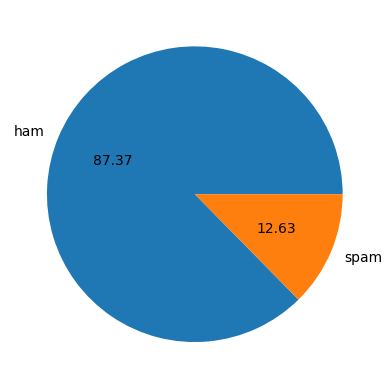

In [ ]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

##### From above plot it can be seen that the data is so much imbalanced

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df.loc[:, 'num_characters'] = df['text'].apply(len)

<ipython-input-22-0a5cc858d627>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'num_characters'] = df['text'].apply(len)


In [ ]:
df

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125


In [ ]:
df.loc[:, 'num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

<ipython-input-24-e557c483a7da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))


In [ ]:
df

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35
5568,0,Will Ì_ b going to esplanade fr home?,37,9
5569,0,"Pity, * was in mood for that. So...any other s...",57,15
5570,0,The guy did some bitching but I acted like i'd...,125,27


In [ ]:
df.loc[:, 'num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

<ipython-input-26-dc5a7e2067dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))


In [ ]:
df

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,0,The guy did some bitching but I acted like i'd...,125,27,1


In [ ]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

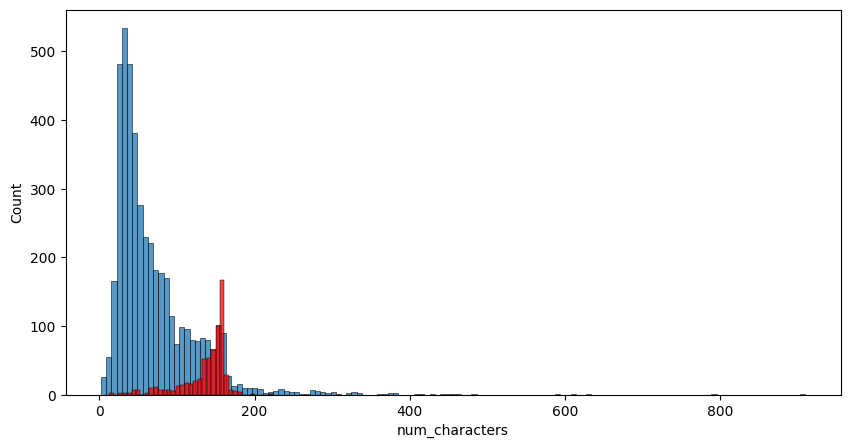

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

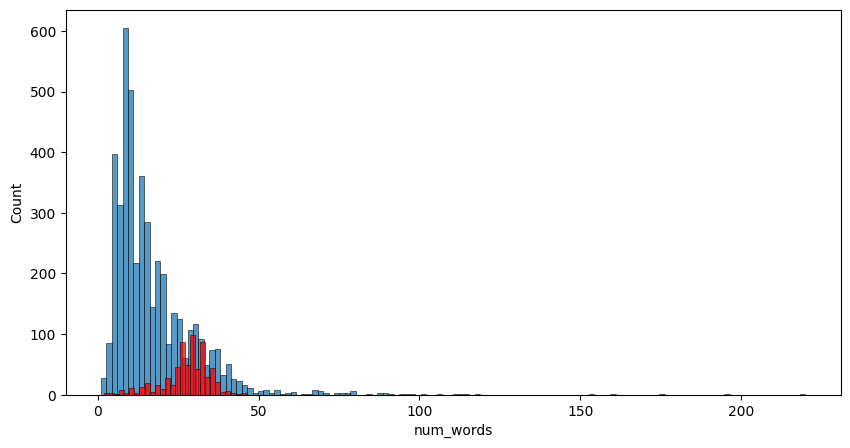

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

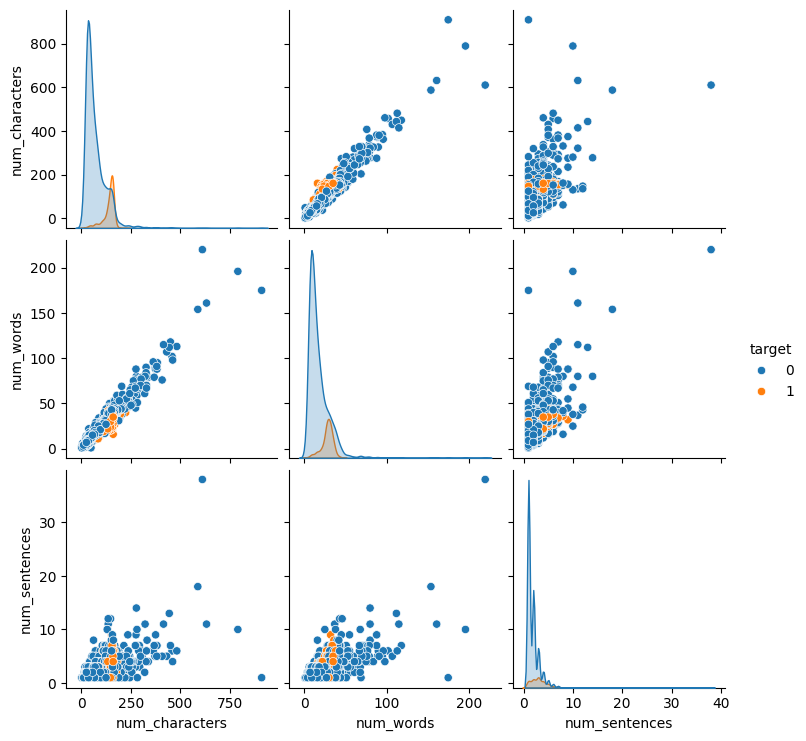

In [ ]:
sns.pairplot(df,hue='target')

# Data Processing


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

nltk.download('punkt')
nltk.download('stopwords')

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    ps = PorterStemmer()
    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [ ]:
df['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
ps.stem('loving')

'love'

In [ ]:
df.loc[:, 'transformed_text'] = df['text'].apply(transform_text)

<ipython-input-38-5664c5bdf8a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'transformed_text'] = df['text'].apply(transform_text)


In [ ]:
df

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
wc

In [ ]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

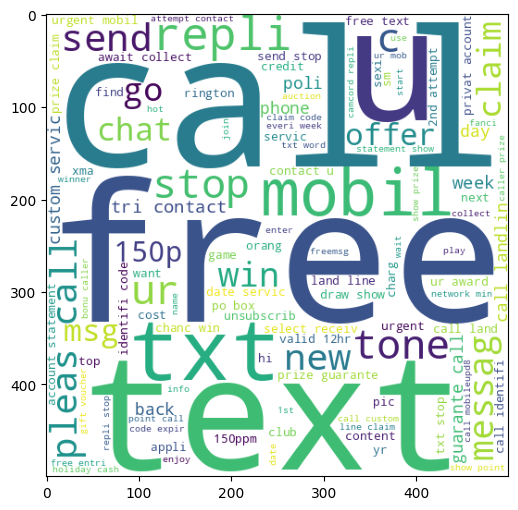

In [ ]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [ ]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

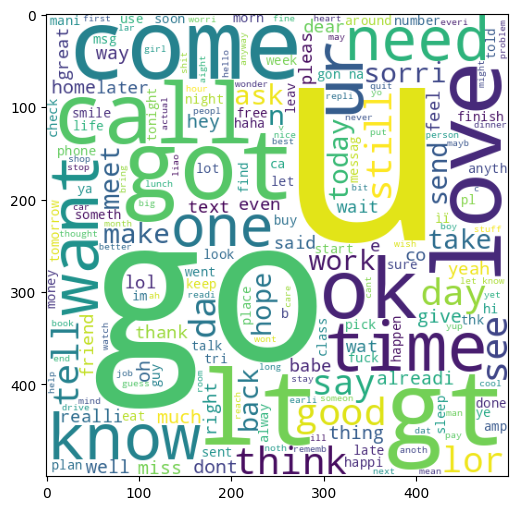

In [ ]:
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [ ]:
df

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


In [ ]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [ ]:
len(spam_corpus)

9939

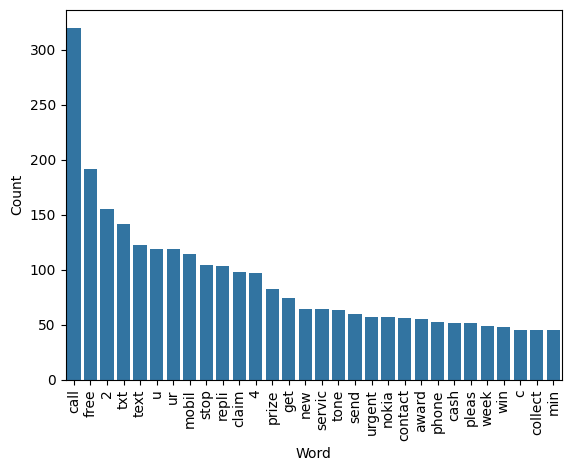

In [ ]:
spam_counts = Counter(spam_corpus).most_common(30)
df_spam_counts = pd.DataFrame(spam_counts, columns=['Word', 'Count'])

sns.barplot(x='Word', y='Count', data=df_spam_counts)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [ ]:
len(ham_corpus)

35404

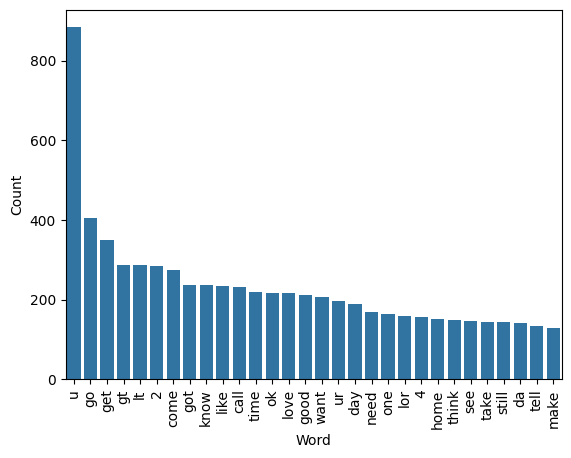

In [ ]:
ham_counts = Counter(ham_corpus).most_common(30)
df_ham_counts = pd.DataFrame(ham_counts, columns=['Word', 'Count'])

sns.barplot(x='Word', y='Count', data=df_ham_counts)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
df

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


# Modeling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [ ]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [ ]:
X.shape

(5169, 3000)

In [ ]:
y = df['target'].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [ ]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [ ]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8694390715667312
[[788 108]
 [ 27 111]]
0.5068493150684932


In [ ]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [ ]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [ ]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [ ]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)

    return accuracy,precision

In [ ]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9758220502901354, 0.9747899159663865)

In [ ]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)

    print("For ",name,":")
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC :
Accuracy -  0.9758220502901354
Precision -  0.9747899159663865
For  KN :
Accuracy -  0.9052224371373307
Precision -  1.0
For  NB :
Accuracy -  0.9709864603481625
Precision -  1.0
For  DT :
Accuracy -  0.9274661508704062
Precision -  0.8118811881188119
For  LR :
Accuracy -  0.9584139264990329
Precision -  0.9702970297029703
For  RF :
Accuracy -  0.9758220502901354
Precision -  0.9829059829059829
For  AdaBoost :
Accuracy -  0.960348162475822
Precision -  0.9292035398230089
For  BgC :
Accuracy -  0.9584139264990329
Precision -  0.8682170542635659
For  ETC :
Accuracy -  0.9748549323017408
Precision -  0.9745762711864406
For  GBDT :
Accuracy -  0.9468085106382979
Precision -  0.9191919191919192
For  xgb :
Accuracy -  0.9671179883945842
Precision -  0.9262295081967213


In [ ]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.970986,1.000000
5,RF,0.975822,0.982906
0,SVC,0.975822,0.974790
8,ETC,0.974855,0.974576
4,LR,0.958414,0.970297
6,AdaBoost,0.960348,0.929204
10,xgb,0.967118,0.926230
9,GBDT,0.946809,0.919192
7,BgC,0.958414,0.868217


In [ ]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.905222
1,NB,Accuracy,0.970986
2,RF,Accuracy,0.975822
3,SVC,Accuracy,0.975822
4,ETC,Accuracy,0.974855
5,LR,Accuracy,0.958414
6,AdaBoost,Accuracy,0.960348
7,xgb,Accuracy,0.967118
8,GBDT,Accuracy,0.946809
9,BgC,Accuracy,0.958414


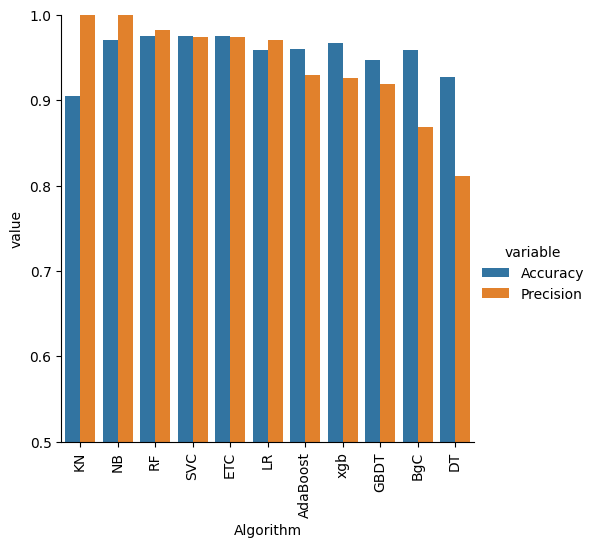

In [ ]:
sns.catplot(x = 'Algorithm', y='value',
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_scores,'Precision_max_ft_3000':precision_scores}).sort_values('Precision_max_ft_3000',ascending=False)

In [ ]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)

In [ ]:
new_df = performance_df.merge(temp_df,on='Algorithm')

In [ ]:
new_df_scaled = new_df.merge(temp_df,on='Algorithm')

In [ ]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)

In [ ]:
new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,KN,0.905222,1.000000,0.905222,1.000000,0.905222,1.000000,0.905222,1.000000
1,NB,0.970986,1.000000,0.970986,1.000000,0.970986,1.000000,0.970986,1.000000
2,RF,0.975822,0.982906,0.975822,0.982906,0.975822,0.982906,0.975822,0.982906
3,SVC,0.975822,0.974790,0.975822,0.974790,0.975822,0.974790,0.975822,0.974790
4,ETC,0.974855,0.974576,0.974855,0.974576,0.974855,0.974576,0.974855,0.974576
5,LR,0.958414,0.970297,0.958414,0.970297,0.958414,0.970297,0.958414,0.970297
6,AdaBoost,0.960348,0.929204,0.960348,0.929204,0.960348,0.929204,0.960348,0.929204
7,xgb,0.967118,0.926230,0.967118,0.926230,0.967118,0.926230,0.967118,0.926230
8,GBDT,0.946809,0.919192,0.946809,0.919192,0.946809,0.919192,0.946809,0.919192
9,BgC,0.958414,0.868217,0.958414,0.868217,0.958414,0.868217,0.958414,0.868217


In [ ]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [ ]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')


In [ ]:
voting.fit(X_train,y_train)

In [ ]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

In [ ]:
# Now we will apply stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [ ]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

# Pickling

In [ ]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))